#**Proyecto Final Hackaton**
## **Integrantes**:
  * Merenda Francisco
  * Michaux Juan Martin

##**Asignatura: Inteligencia Artificial**
##**Docentes**:
* Bioing. Agustina Ricci
* Bioing. Ignacio Bosch

#**Online Shoppers Purchasing Intention Dataset**
[URL Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)

Este conjunto de datos contiene información de las visitas de usuarios a un sitio de comercio electrónico, con el objetivo de analizar su intención de compra. Se compone de diez atributos numéricos y ocho atributos categóricos que capturan distintos aspectos del comportamiento de navegación del usuario y las características de la sesión. El atributo clave, Revenue, indica si una sesión específica finalizó en una transacción (compra), y puede utilizarse como la etiqueta de clase en modelos de clasificación.

# **Descripción de Atributos**

###**Atributos de Navegación y Tiempo:**


**Administrative, Administrative Duration, Informational, Informational Duration, Product Related, y Product Related Duration:**
Estos atributos registran el número de páginas visitadas de distintos tipos (administrativas, informativas y de productos) y el tiempo total que el usuario dedica en cada categoría de página durante una sesión.
Estos valores se obtienen en tiempo real, actualizándose cada vez que el usuario realiza una acción (por ejemplo, navegar entre páginas).

###**Métricas de Interacción:**


**Bounce Rate, Exit Rate, Page Value:**


*   Bounce Rate: Representa el porcentaje de visitantes que ingresan al sitio desde una página específica y luego abandonan el sitio sin realizar ninguna otra acción.

*   Exit Rate: Indica el porcentaje de visitantes para los cuales una página fue la última de la sesión.

*   Page Value: Muestra el valor promedio de una página que fue visitada antes de completar una transacción.


###**Día Especial:**

**Special Day**:

Refleja la cercanía de la fecha de visita a un día especial (como San Valentín o el Día de la Madre), en el cual es más probable que las visitas terminen en una transacción.
Los valores de este atributo varían de 0 a 1, siendo 1 el día más cercano a una fecha especial. Por ejemplo, para el 8 de febrero, cercano a San Valentín, este valor es máximo (1) y decrece al alejarse de la fecha.

###**Información Adicional de la Sesión:**

**Operating System, Browser, Region, Traffic Type:**


Proporcionan información sobre el dispositivo y tipo de tráfico de la sesión.

Visitor Type: Diferencia entre usuarios recurrentes y nuevos.

Weekend: Valor booleano que indica si la sesión ocurrió en fin de semana.

Month: Mes del año en el que se registró la visita.

Instalación de Librerias

In [ ]:
!pip install wandb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de librerías:

In [ ]:
#Montar el sistema de archivos
from google.colab import drive

import pandas as pd
import numpy as np

#PREPROCESAMIENTO
from sklearn.preprocessing import LabelEncoder, StandardScaler

#MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#ENTRENAMIENTO Y OPTIMIZACIÓN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#METRICAS
import sklearn.metrics as metrics

#PLOTEO
import matplotlib.pyplot as plt
import seaborn as sns

#WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# PROFES
# Los agregamos como colaboradores en wandbpor si querían observar los logs y las gráficas del entrenamiento de los modelos.

import wandb

# Inicia sesión en wandB
wandb.login(key="e9ab44a59607adc62e0e28856520e79af1f9eb50")

# Inicia un proyecto de wandB
wandb.init(project="online_shoppers_intent", name="Hackaton_Online_Shoppers")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mjuammartin (mjuammartin-universidad-de-mendoza). Use `wandb login --relogin` to force relogin


# Definición de funciones:

In [ ]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 5
    tamanio_fig = 5
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1',
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 5
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins,
                   density = density, title=('%s' % feat))

# Lectura de datos:

In [ ]:
# Montar el sistema de archivos de Google Drive en la ubicación '/content/gdrive'
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
# Definir la ruta del archivo CSV en Google Drive
filename ="/content/gdrive/MyDrive/Proyecto Final Ia/online_shoppers_intention.csv"


# Leer el archivo CSV utilizando pandas y cargarlo en un DataFrame llamado 'df'
XY = pd.read_csv(filename, delimiter=",")

In [ ]:
XY[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


LOG DE **WANDB**

In [ ]:
XY.head()
wandb.log({"dataset_head": wandb.Table(dataframe=XY.head())})

In [ ]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:50]

- El número de filas en el dataset es: 12330
- El número de columnas en el dataset es: 18
- Los nombres de las variables son: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.000000,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.000000,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.000000,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


# Preprocesamiento de datos

## Missings:

In [ ]:
XY.isnull().sum() #Buscamos valores nulos en cada variable

,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


## Descriptivos básicos:

In [ ]:
XY.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Categóricas a numéricas:

In [ ]:
XY.select_dtypes(exclude=['number']).columns

Index(['Month', 'VisitorType', 'Weekend', 'Revenue'], dtype='object')

##Month

In [ ]:
XY['Month'].value_counts()

,count
Month,
May,3364
Nov,2998
Mar,1907
Dec,1727
Oct,549
Sep,448
Aug,433
Jul,432
June,288


In [ ]:
le = LabelEncoder()
XY.Month= le.fit_transform(XY.Month.values)

In [ ]:
XY

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,1,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,7,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,7,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,7,2,2,3,11,Returning_Visitor,False,False


##VisitorType

In [ ]:
XY['VisitorType'].value_counts()

,count
VisitorType,
Returning_Visitor,10551
New_Visitor,1694
Other,85


In [ ]:
#Las muestras que sean distintas de Returning_Visitor los codificamos como 0s, los Returning_Visitor como 1s.

XY.loc[XY['VisitorType'] != 'Returning_Visitor', 'VisitorType'] = 0   #visitante nuevo
XY.loc[XY['VisitorType'] == 'Returning_Visitor', 'VisitorType'] = 1   #visitante frecuente
XY['VisitorType'] = XY['VisitorType'].astype(int)

##Weekend

In [ ]:
XY['Weekend'].value_counts()

,count
Weekend,
False,9462
True,2868


In [ ]:
XY.loc[XY['Weekend'] == 'False', 'Weekend'] = 0
XY.loc[XY['Weekend'] == 'True', 'Weekend'] = 1
XY['Weekend'] = XY['Weekend'].astype(int)

##Revenue

In [ ]:
XY['Revenue'].value_counts()

,count
Revenue,
False,10422
True,1908


In [ ]:
XY.loc[XY['Revenue'] == 'False', 'Revenue'] = 0
XY.loc[XY['Revenue'] == 'True', 'Revenue'] = 1
XY['Revenue'] = XY['Revenue'].astype(int)

##SpecialDay

In [ ]:
XY['SpecialDay'].value_counts()

,count
SpecialDay,
0.0,11079
0.6,351
0.8,325
0.4,243
0.2,178
1.0,154


In [ ]:
XY.loc[XY['SpecialDay'] != 0, 'SpecialDay'] = 1
XY['SpecialDay'] = XY['SpecialDay'].astype(int)

## Revisión de variables categóricas:

In [ ]:
# Lista de variables categóricas
XY.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

## Division en features X + target Y




In [ ]:
X = XY.drop('Revenue', axis=1)
Y = XY['Revenue']

## Descriptivos básicos:

In [ ]:
XY.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.101460,5.163990,2.124006,2.357097,3.147364,4.069586,0.855718,0.232603,0.154745
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.301949,2.370199,0.911325,1.717277,2.401591,4.025169,0.351390,0.422509,0.361676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,1.000000,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,7.000000,3.000000,2.000000,4.000000,4.000000,1.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,9.000000,8.000000,13.000000,9.000000,20.000000,1.000000,1.000000,1.000000


## Boxplots:

In [ ]:
X_normalizado = (X-X.mean())/X.std() #Aca sacamos el valor Z que indica cuan desviado está el valor de la media. Un valor > 3 en ABS se considera outlier.

In [ ]:
X_normalizado[:10]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,-0.696965,-0.457173,-0.396462,-0.244921,-0.690975,-0.624322,3.667040,3.229185,-0.317165,-0.336017,-1.334905,-1.233376,-0.790261,-0.894142,-0.762598,0.410604,-0.550529
1,-0.696965,-0.457173,-0.396462,-0.244921,-0.668491,-0.590879,-0.457664,1.171425,-0.317165,-0.336017,-1.334905,-0.136073,-0.207943,-0.894142,-0.514161,0.410604,-0.550529
2,-0.696965,-0.457173,-0.396462,-0.244921,-0.690975,-0.624322,3.667040,3.229185,-0.317165,-0.336017,-1.334905,2.058534,-0.790261,2.436983,-0.265725,0.410604,-0.550529
3,-0.696965,-0.457173,-0.396462,-0.244921,-0.668491,-0.622929,0.573512,1.994529,-0.317165,-0.336017,-1.334905,0.961231,-0.207943,-0.477752,-0.017288,0.410604,-0.550529
4,-0.696965,-0.457173,-0.396462,-0.244921,-0.488617,-0.296418,-0.045194,0.142545,-0.317165,-0.336017,-1.334905,0.961231,0.374374,-0.894142,-0.017288,0.410604,1.816286
5,-0.696965,-0.457173,-0.396462,-0.244921,-0.286258,-0.543735,-0.132030,-0.380920,-0.317165,-0.336017,-1.334905,-0.136073,-0.207943,-0.894142,-0.265725,0.410604,-0.550529
6,-0.696965,-0.457173,-0.396462,-0.244921,-0.690975,-0.624322,3.667040,3.229185,-0.317165,2.975802,-1.334905,-0.136073,0.956691,-0.061361,-0.265725,0.410604,-0.550529
7,-0.395922,-0.457173,-0.396462,-0.244921,-0.713459,-0.624322,3.667040,3.229185,-0.317165,-0.336017,-1.334905,-1.233376,-0.207943,-0.894142,0.231149,0.410604,1.816286
8,-0.696965,-0.457173,-0.396462,-0.244921,-0.668491,-0.604988,-0.457664,1.171425,-0.317165,2.975802,-1.334905,-0.136073,-0.207943,-0.477752,-0.265725,0.410604,-0.550529
9,-0.696965,-0.457173,-0.396462,-0.244921,-0.646007,-0.238676,-0.457664,-0.429055,-0.317165,2.975802,-1.334905,-0.136073,0.956691,-0.894142,-0.514161,0.410604,-0.550529


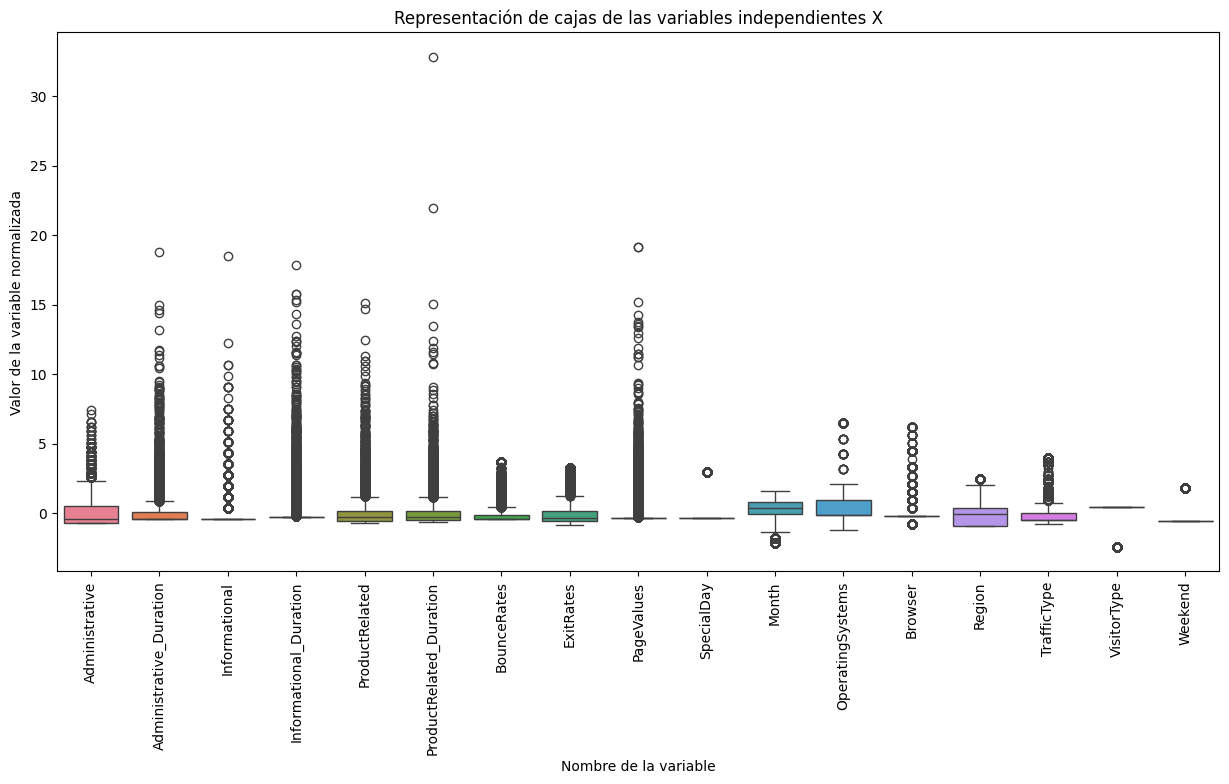

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

## Histogramas:

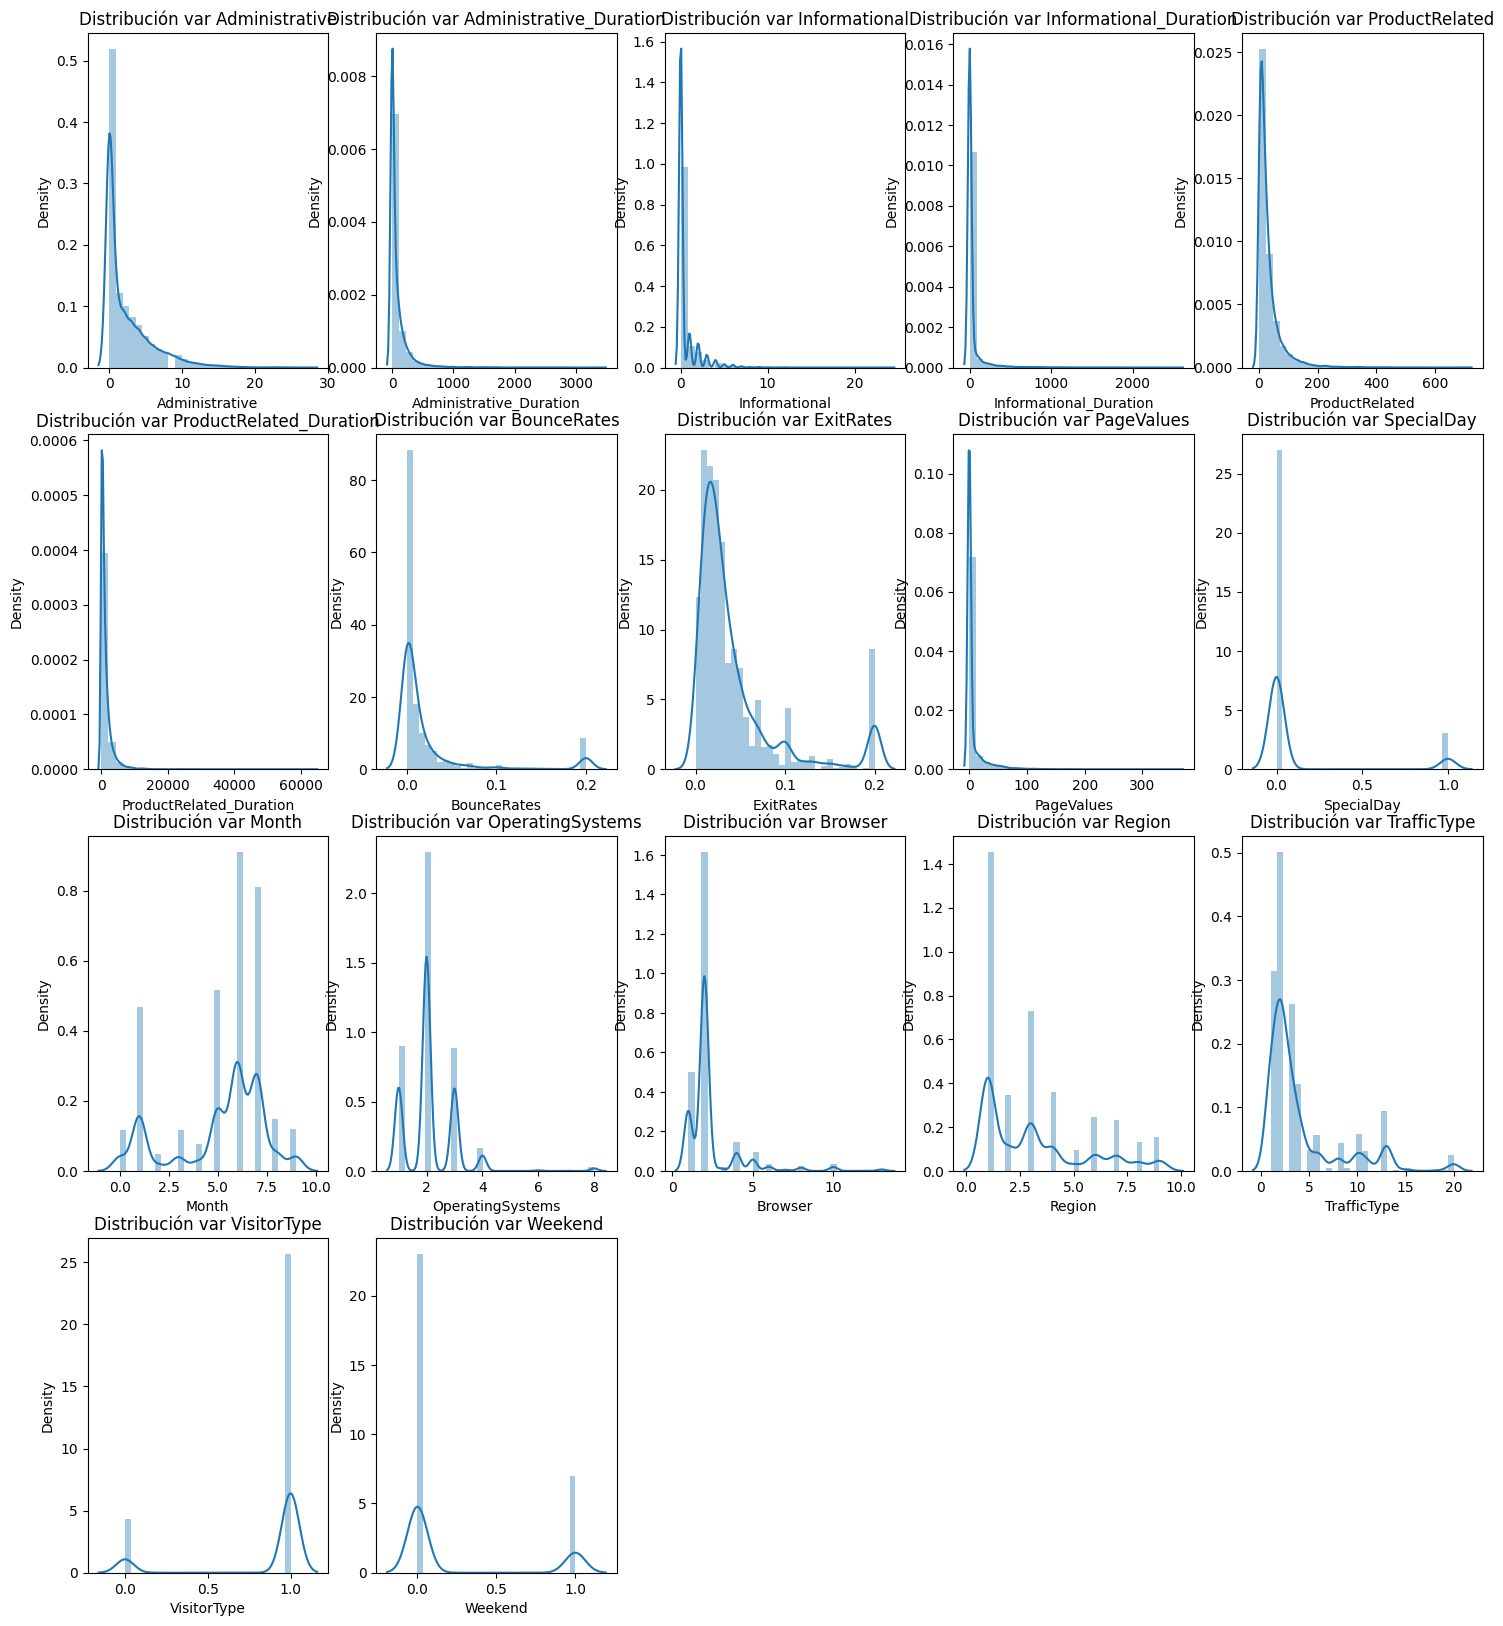

In [ ]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variables de X vs Revenue Y:

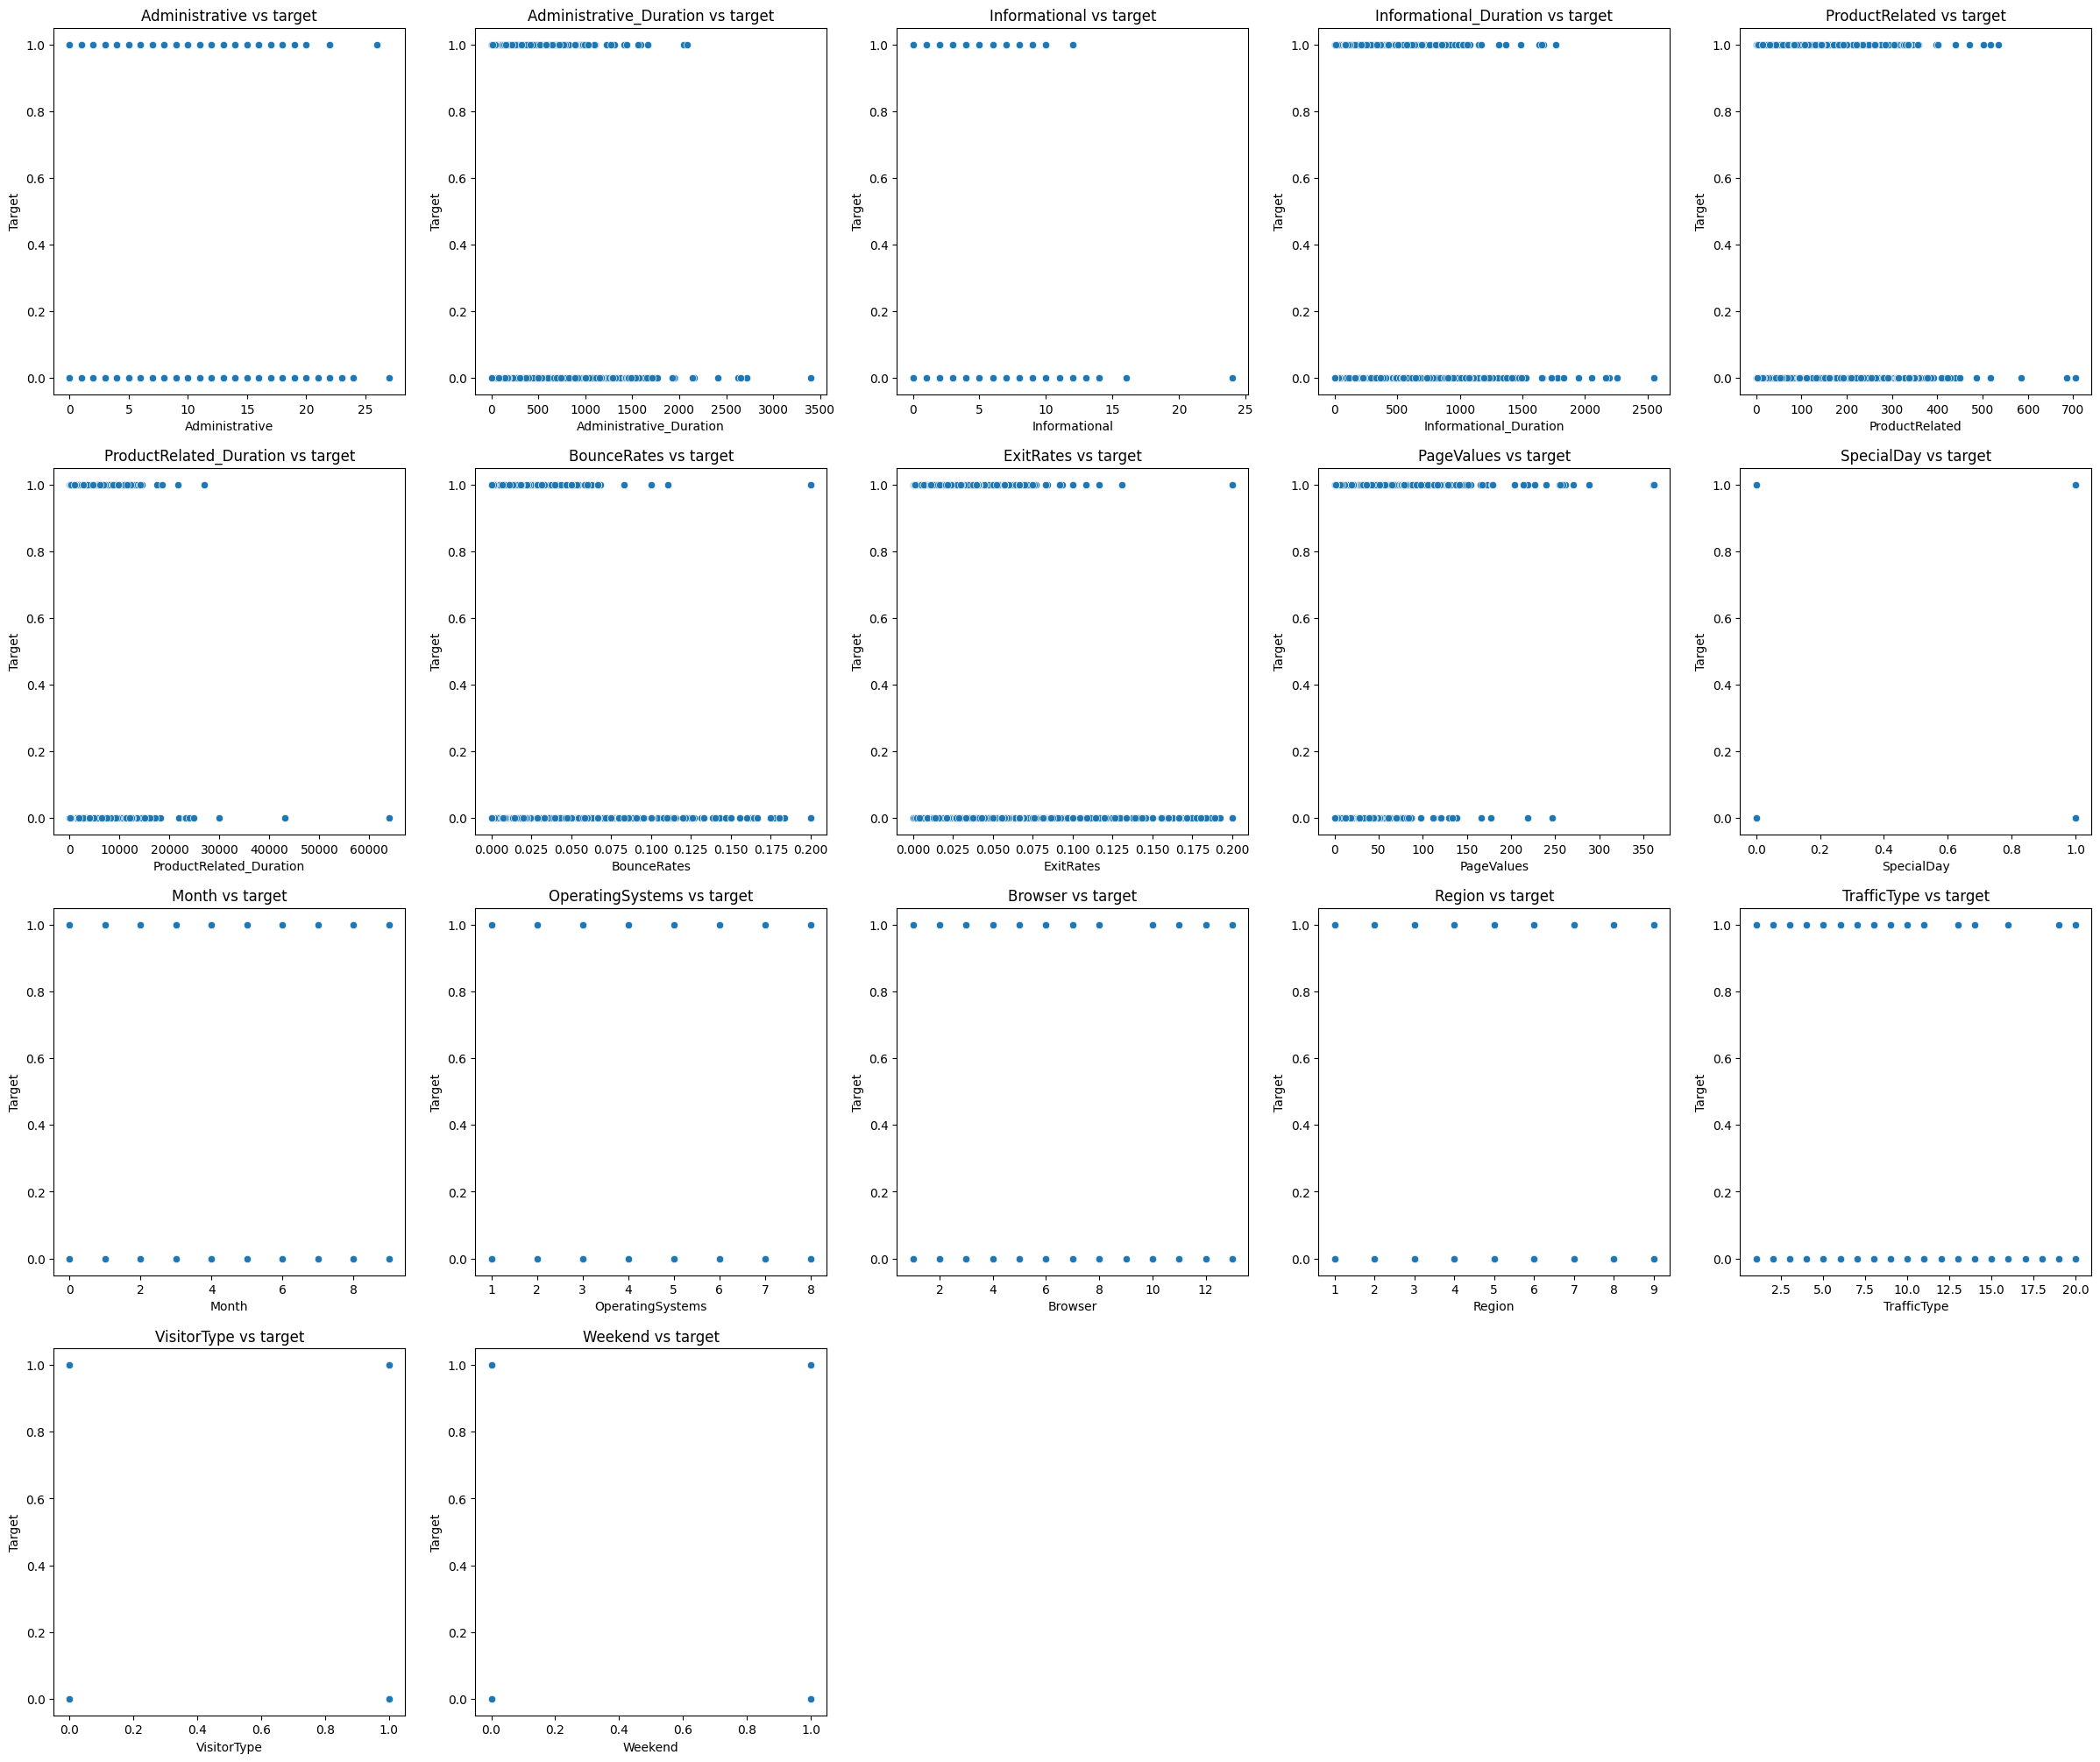

In [ ]:
relaciones_vs_target(X, Y)

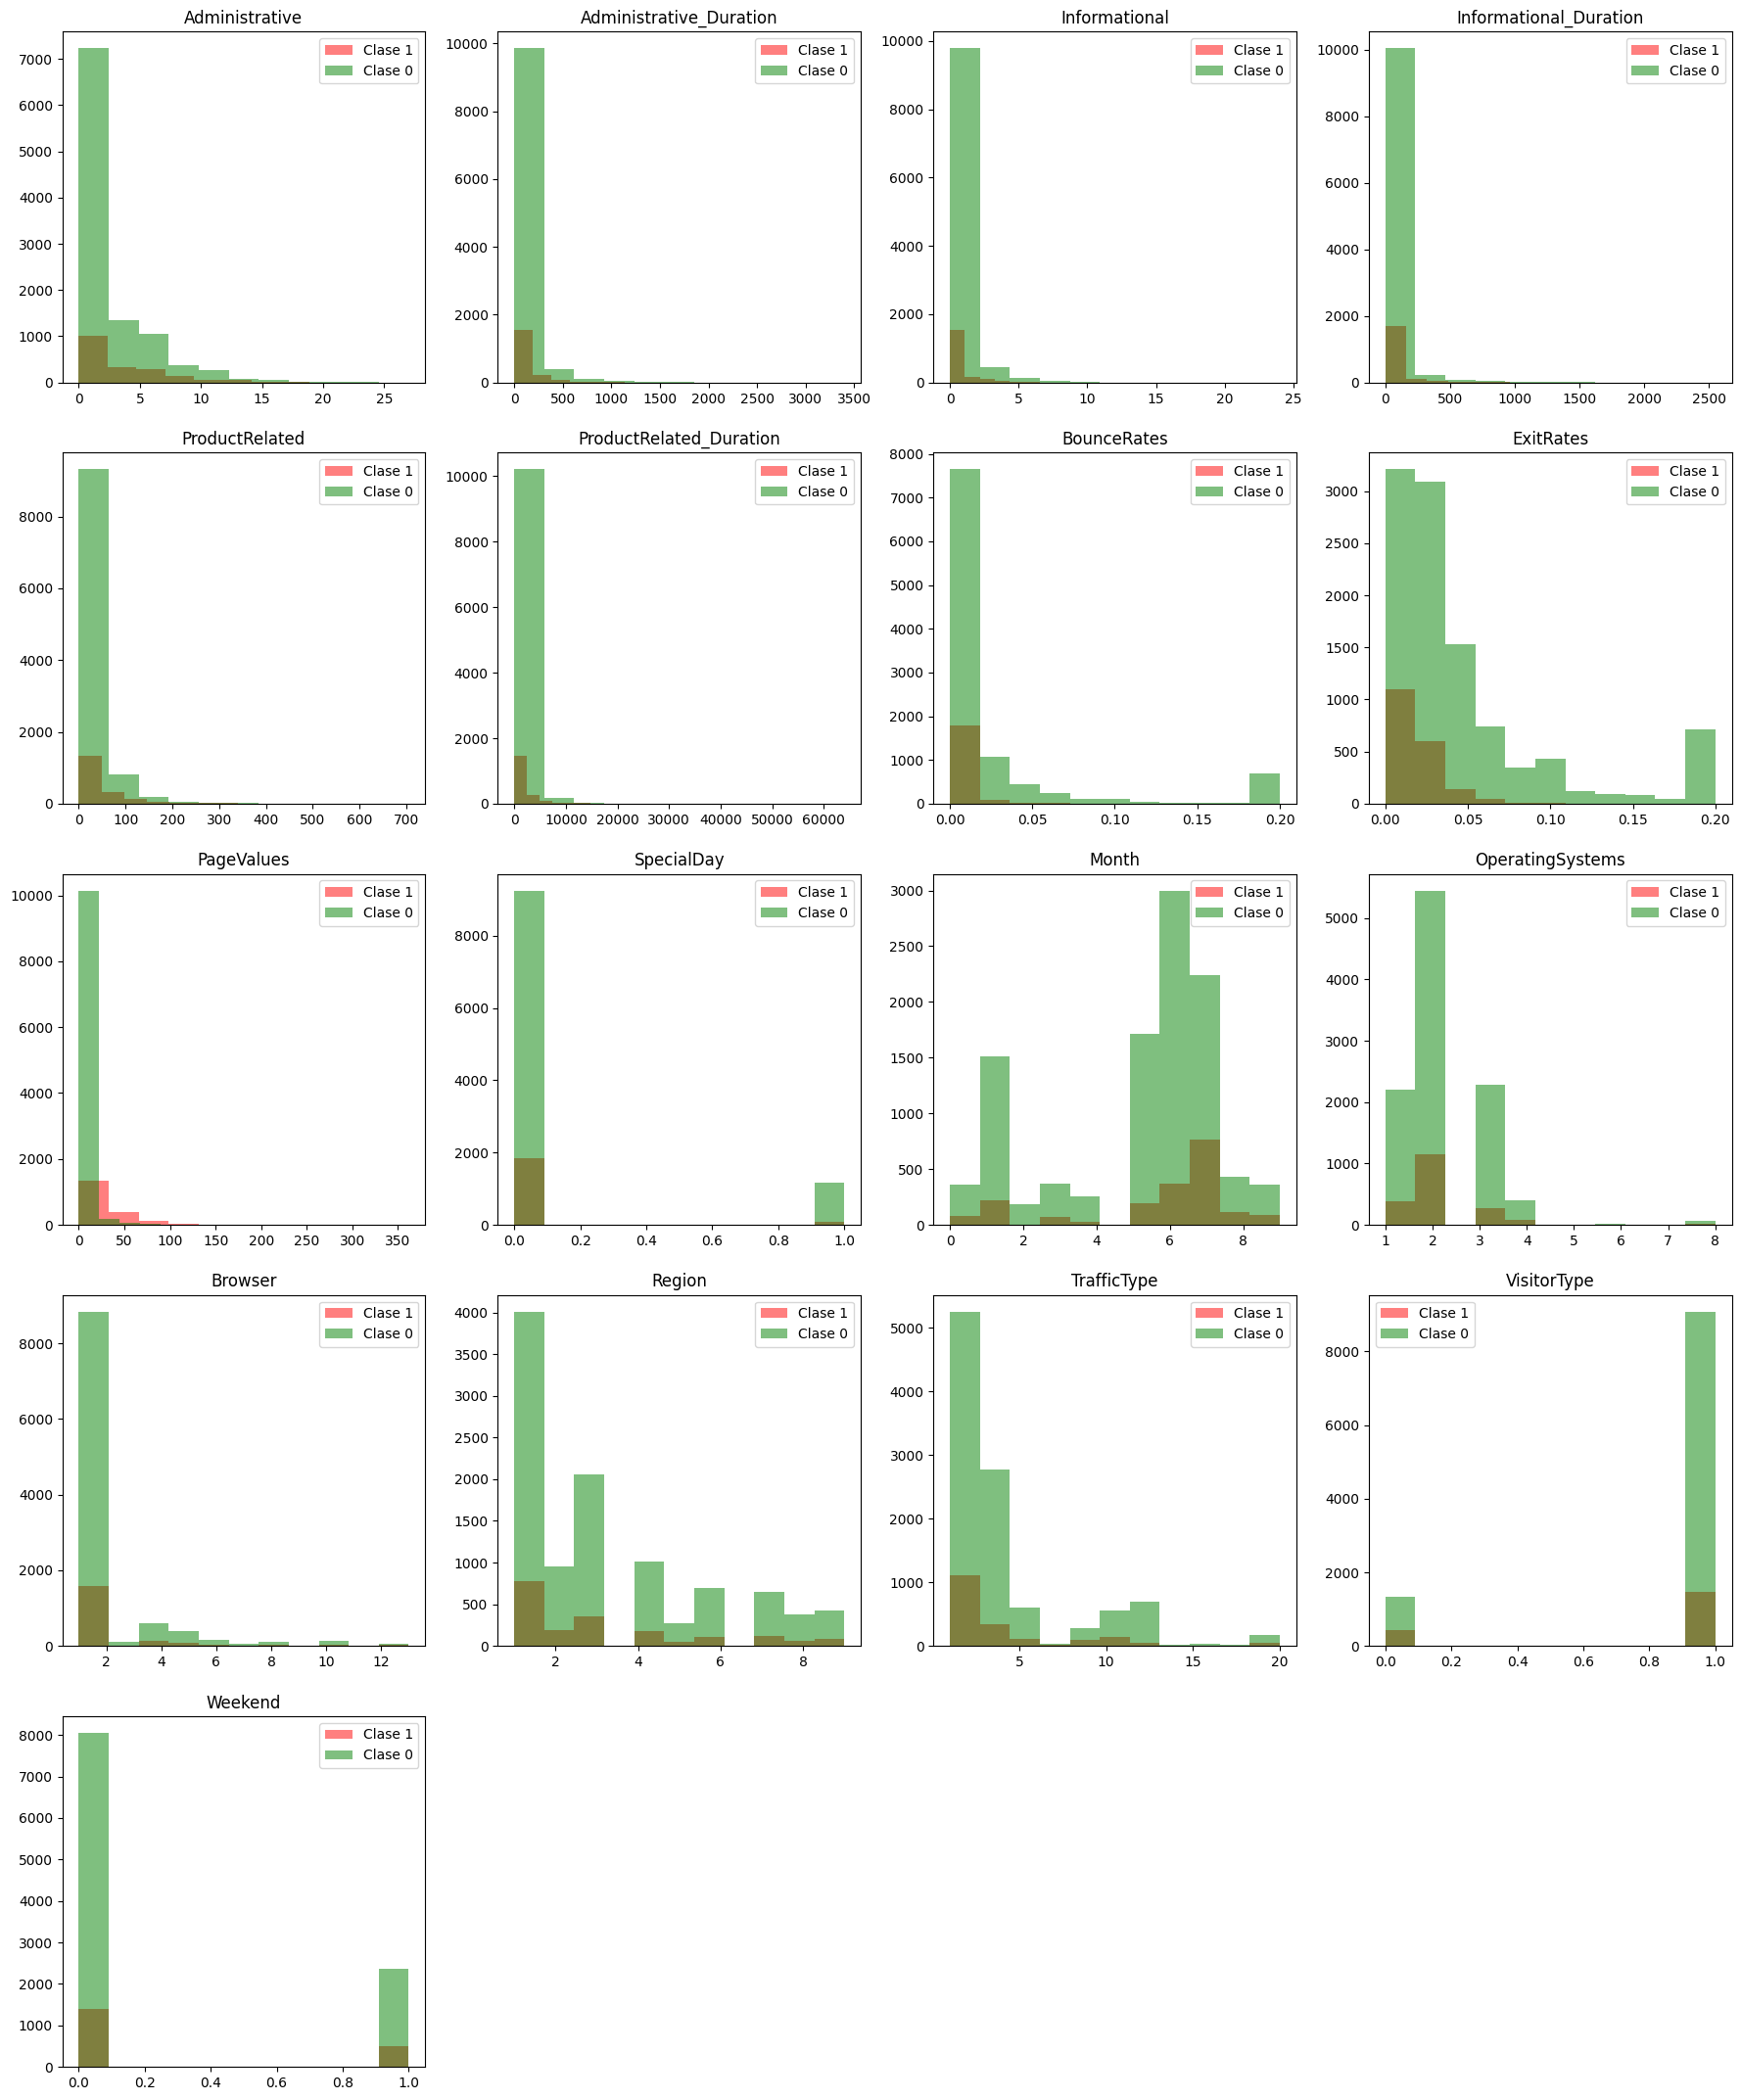

In [ ]:
hist_pos_neg_feat(X,Y)

## Matriz de correlaciones:

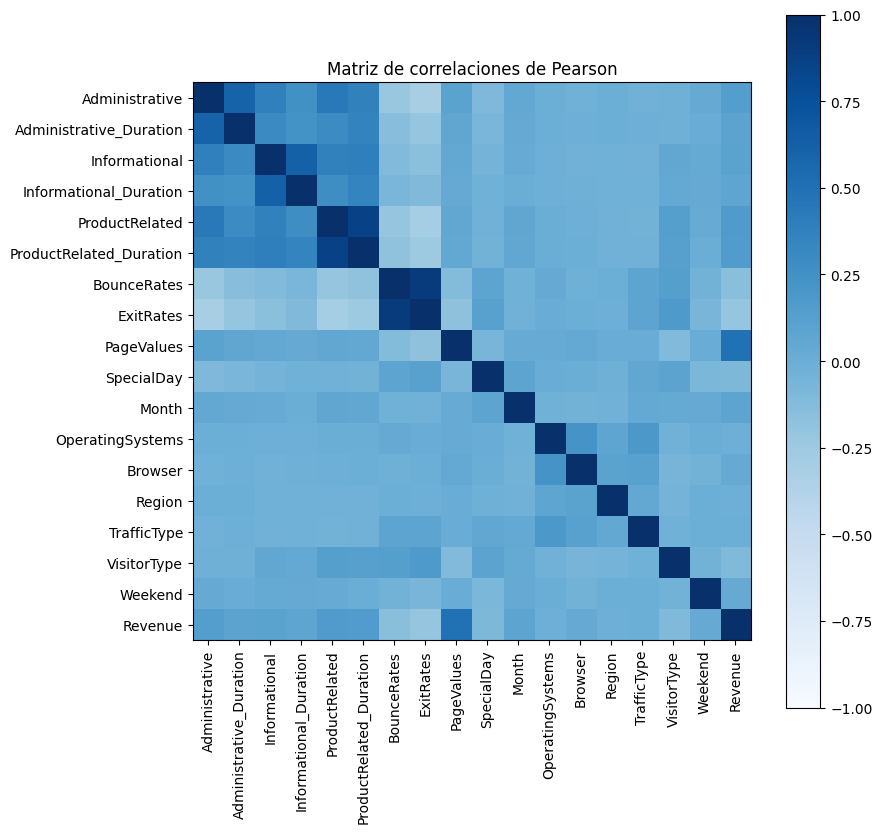

In [ ]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest',
                            vmin=-1., vmax=1.,
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

# Guardar la figura y log en wandB
fig = plt.gcf()  # Obtiene la figura actual
wandb.log({"correlation_matrix": wandb.Image(fig)})
plt.show()

## Variables con mayor correlación con la target:

In [ ]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PageValues,0.492569
ExitRates,-0.207071
ProductRelated,0.158538
ProductRelated_Duration,0.152373
BounceRates,-0.150673
Administrative,0.138917
VisitorType,-0.103843
Informational,0.095200
Administrative_Duration,0.093587
SpecialDay,-0.086589


## Estandarización de los datos previa:

In [ ]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

In [ ]:
# Guardar una versión de los datos procesados en wandB
processed_data_sample = pd.DataFrame(X_train).head()
wandb.log({"processed_data_sample": wandb.Table(dataframe=processed_data_sample)})

## MODELO DE REGRESIÓN LOGÍSTICA


## Aplica el modelo por defecto:

In [ ]:
# Ajusta el modelo por defecto a los datos de entrenamiento y predice test
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
# Predice las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
# Se calcula con esta función... sklearn.metrics.roc_auc_score(y_true, y_score[:,1])
y_test_pred_prob = modelo.predict_proba(X_test)
roc_auc = metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

# Registro del AUC-ROC en wandB
wandb.log({"ROC_AUC_Score": roc_auc})

## Optimiza los parámetros:

In [ ]:
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09],
              "class_weight":['balanced', None]}

In [ ]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)


# Registro de los mejores parámetros y AUC de validación cruzada en wandB
wandb.log({
    "Best_C": modelo_gs.best_params_['C'],
    "Best_class_weight": modelo_gs.best_params_['class_weight'],
    "GridSearch_ROC_AUC": modelo_gs.best_score_
})

In [ ]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.09, 'class_weight': 'balanced'} 
ROC AUC: 0.89


In [ ]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

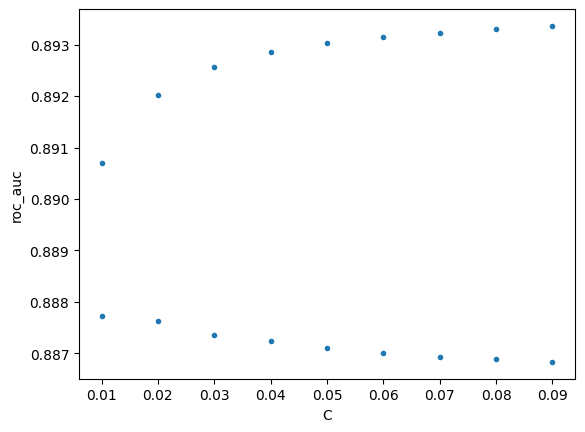

In [ ]:
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [ ]:
reg_log =  LogisticRegression(C=modelo_gs.best_params_['C'],
                              class_weight=modelo_gs.best_params_['class_weight'])

In [ ]:
reg_log.fit(X_train, Y_train)

LogisticRegression(C=0.09, class_weight='balanced')

In [ ]:
y_test_pred_prob = reg_log.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

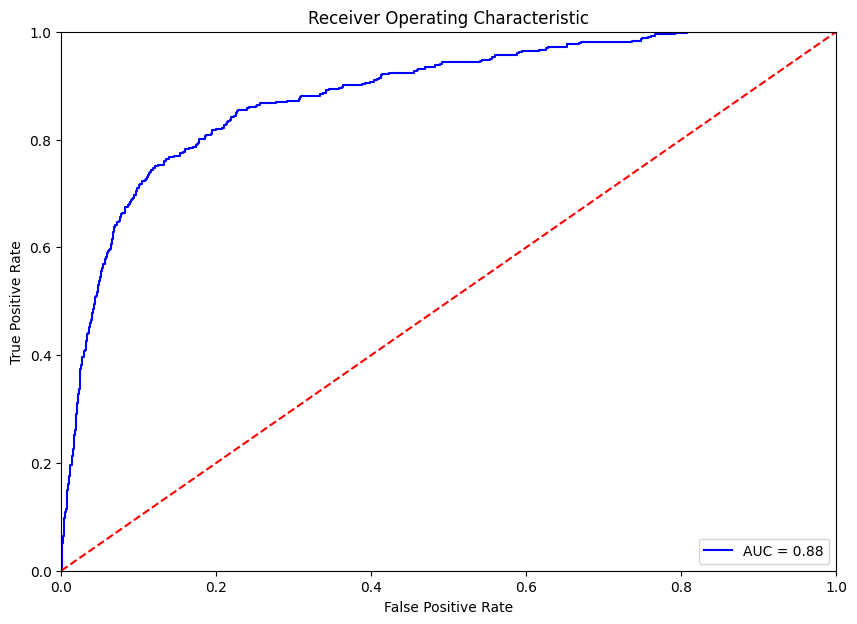

In [ ]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_optimized = metrics.auc(fpr, tpr)

# Registro del AUC-ROC en wandB
wandb.log({"Logistic_Regression_Optimized_ROC_AUC": roc_auc_optimized})

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_optimized)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

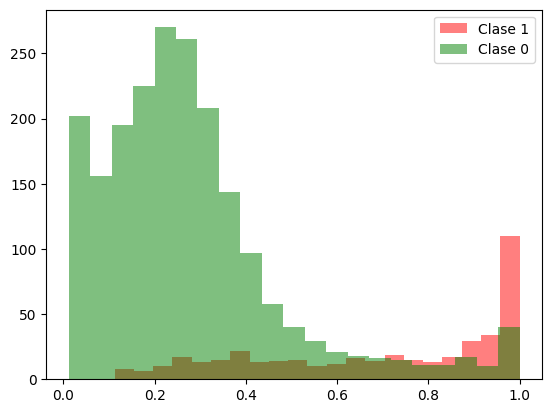

In [ ]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

##Umbralizo las predicciones:

In [ ]:
umbral = 0.4
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [ ]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))

Matriz de confusión
 [[1688  356]
 [  90  332]]

Accuracy	0.82
Sensitividad	0.79
Precisión	0.48


In [ ]:

#APUNTES
#Metrica sensitividad es el porcentaje de los casos positivos detectados

#Con la sensitividad nos aseguramos que mientras mayor sea, menor porcentaje de positivos dejaremos afuera de la clasificación.
#Evaluando esta metrica nos aseguramos que el modelo clasifique los que son 1 se clasifiquen
#como 1 para enfocar en los perfiles o comportamiento de los posibles compradores


#Si nos movemos un poco para la clase 0 no nos importa porque pueden ser posibles compradores segun su comportamiento.

In [ ]:
# Registro de la matriz de confusión y métricas en wandB
wandb.log({
    "Confusion_Matrix": metrics.confusion_matrix(Y_test, y_umbralizadas),
    "Accuracy": round(metrics.accuracy_score(Y_test, y_umbralizadas),2),
    "Sensitividad": round(metrics.recall_score(Y_test, y_umbralizadas),2),
    "Precision": round(metrics.precision_score(Y_test, y_umbralizadas),2)
})

## MODELO DE MULTILAYER PERCEPTRON CLASSIFIER


## Aplica el modelo por defecto:

In [ ]:
#Ajusta el modelo por defecto a los datos de entrenamiento y predice test
modelo = MLPClassifier()
modelo.fit(X_train, Y_train)

MLPClassifier()

In [ ]:
#Predice las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
# Se calcula con esta función... sklearn.metrics.roc_auc_score(y_true, y_score[:,1])
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

# Registro del AUC-ROC en wandB
wandb.log({"ROC_AUC_Score": roc_auc})

## Optimiza los parámetros:

In [ ]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'],
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(25, 30), # Número de neuronas en cada capa
              'random_state':[0]}

In [ ]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3,
                         scoring='roc_auc', n_jobs=-1, verbose=10)
modelo_gs.fit(X_train, Y_train)

# Registro de los mejores parámetros y AUC de validación cruzada en wandB
wandb.log({
    "Best_alpha": modelo_gs.best_params_.get('alpha', 'Not Found'),
    "Best_hidden_layer_sizes": modelo_gs.best_params_.get('hidden_layer_sizes', 'Not Found'),
    "Best_max_iter": modelo_gs.best_params_.get('max_iter', 'Not Found'),
    "Best_random_state": modelo_gs.best_params_.get('random_state', 'Not Found'),
    "Best_solver": modelo_gs.best_params_.get('solver', 'Not Found'),
    "GridSearch_ROC_AUC": modelo_gs.best_score_
})

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [ ]:
print("Best parameters found:", modelo_gs.best_params_)

Best parameters found: {'alpha': 0.01, 'hidden_layer_sizes': 26, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'}


In [ ]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.01, 'hidden_layer_sizes': 26, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.9


In [ ]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10, early_stopping=True )

#EarlyStopping
#clf = MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, validation_fraction=0.2)

In [ ]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=26,
              max_iter=100, random_state=0, solver='lbfgs', verbose=10)

Análisis de las predicciones

In [ ]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

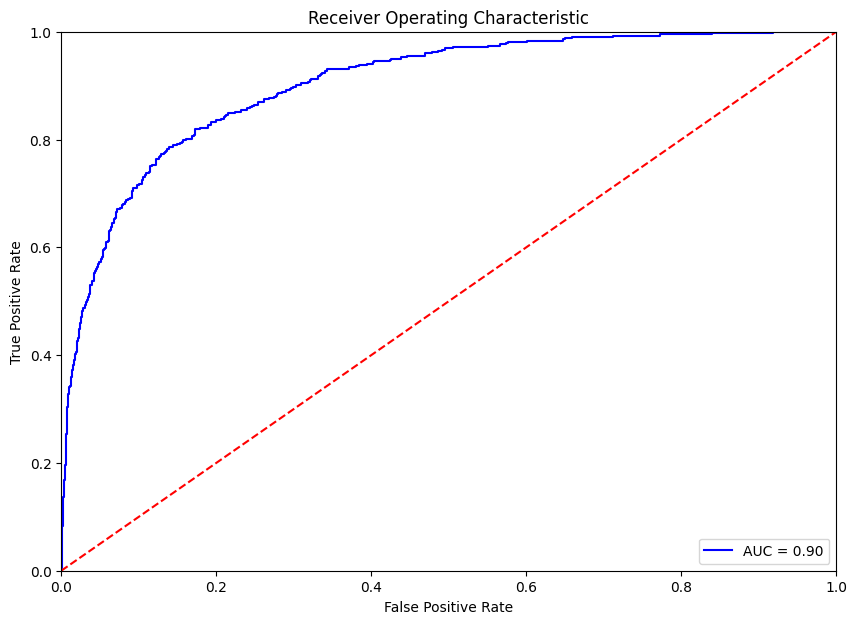

In [ ]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_optimized = metrics.auc(fpr, tpr)

# Registro del AUC-ROC en wandB
wandb.log({"MLPClassifier_Optimized_ROC_AUC": roc_auc_optimized})

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_optimized)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

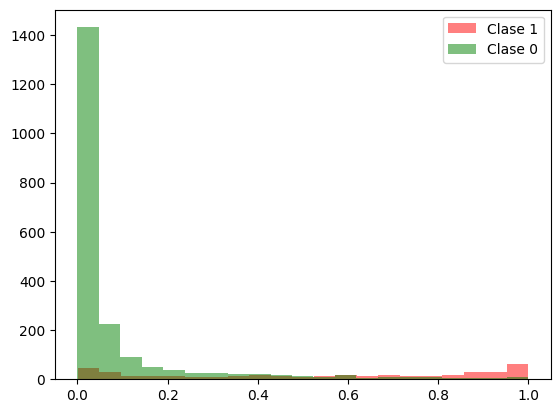

In [ ]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

##Umbralizo las predicciones:

In [ ]:
umbral = 0.4
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [ ]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))

Matriz de confusión
 [[1914  130]
 [ 155  267]]

Accuracy	0.88
Sensitividad	0.63
Precisión	0.67


In [ ]:
# Registro de la matriz de confusión y métricas en wandB
wandb.log({
    "Confusion_Matrix": metrics.confusion_matrix(Y_test, y_umbralizadas),
    "Accuracy": round(metrics.accuracy_score(Y_test, y_umbralizadas),2),
    "Sensitividad": round(metrics.recall_score(Y_test, y_umbralizadas),2),
    "Precision": round(metrics.precision_score(Y_test, y_umbralizadas),2)
})

In [ ]:
#Creo que el entrenamiento para el modelo MLP quedó sobreajustado ya que es muy tajante en la predicción dando poca sensitividad que es la metrica buscada
#Para que el modelo no se sobre ajuste se intenta aplicar las siguientes dos tecnicas y probar resultados.
#Regularización L2
#Inicialmente se ejecuto con alpha = 10 lo cual indica un rango 0.1 a 0.01
#Se probó alpha =20 pero el resultado no fue el esperado
#Early Stopping

## MODELO RANDOM FOREST CLASSIFIER


##Aplico modelo por defecto:

In [ ]:
# Ajusta el modelo por defecto a los datos de entrenamiento y predice test
modelo = RandomForestClassifier()
modelo.fit(X_train, Y_train)

RandomForestClassifier()

In [ ]:
# Predice las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
# Se calcula con esta función... sklearn.metrics.roc_auc_score(y_true, y_score[:,1])
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

# Registro del AUC-ROC en wandB
wandb.log({"ROC_AUC_Score": roc_auc})

##Optimizo los parámetros:

In [ ]:
# Se define un modelo Random Forest y se encuentran los mejores hiperparámetros
clf = RandomForestClassifier()
params = {"n_estimators" : [10, 50, 100, 200],
"max_depth" : [5, 7, 9],
"max_features": [10, "sqrt"]}

In [ ]:
clf_grid = GridSearchCV(clf, params, cv=3, n_jobs=-1)

clf_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [10, 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

In [ ]:
print(clf_grid.best_params_, "\nROC AUC: {}".format(round(clf_grid.best_score_,2)))

{'max_depth': 7, 'max_features': 10, 'n_estimators': 100} 
ROC AUC: 0.91


In [ ]:
n_estimators = clf_grid.best_params_['n_estimators']
max_depth = clf_grid.best_params_['max_depth']
max_features = clf_grid.best_params_['max_features']

mejor_modelo = RandomForestClassifier(max_depth=max_depth,max_features=max_features,verbose=10, n_estimators=n_estimators)

In [ ]:
mejor_modelo.fit(X_train, Y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.7s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    1.4s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.7s


building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    2.1s


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    2.5s


RandomForestClassifier(max_depth=7, max_features=10, verbose=10)

In [ ]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s


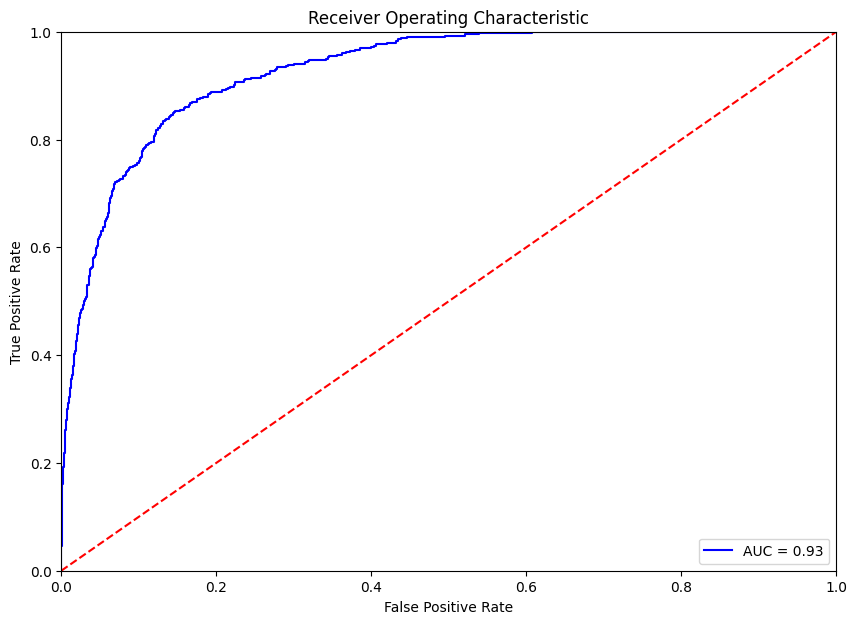

In [ ]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc_optimized = metrics.auc(fpr, tpr)

# Registro del AUC-ROC en wandB
wandb.log({"RandomForestClassifier_Optimized_ROC_AUC": roc_auc_optimized})

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_optimized)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

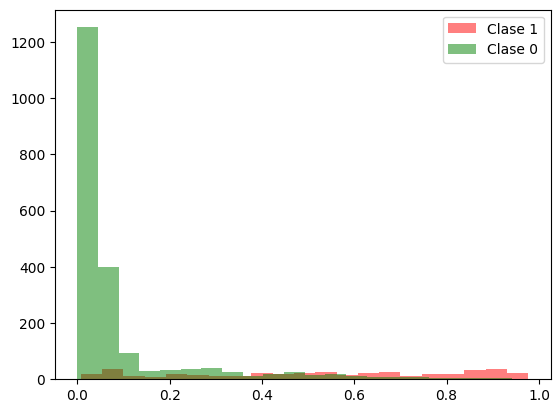

In [ ]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

##Umbralizo las predicciones:

In [ ]:
umbral = 0.4
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [ ]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))

Matriz de confusión
 [[1916  128]
 [ 134  288]]

Accuracy	0.89
Sensitividad	0.68
Precisión	0.69


In [ ]:
# Registro de la matriz de confusión y métricas en wandB
wandb.log({
    "Confusion_Matrix": metrics.confusion_matrix(Y_test, y_umbralizadas),
    "Accuracy": round(metrics.accuracy_score(Y_test, y_umbralizadas),2),
    "Sensitividad": round(metrics.recall_score(Y_test, y_umbralizadas),2),
    "Precision": round(metrics.precision_score(Y_test, y_umbralizadas),2)
})

In [ ]:
wandb.finish()

Accuracy,▁▇█
Best_C,▁
Best_alpha,▁
Best_hidden_layer_sizes,▁
Best_max_iter,▁
Best_random_state,▁
GridSearch_ROC_AUC,▁█
Logistic_Regression_Optimized_ROC_AUC,▁
MLPClassifier_Optimized_ROC_AUC,▁
Precision,▁▇█
ROC_AUC_Score,▁▁▁


In [ ]:
'''
LogisticRegression
Matriz de confusión
 [[1688  356]
 [  90  332]]

Accuracy	0.82
Sensitividad	0.79  <------Métrica elegida
Precisión	0.48

#MLPClassifier
Matriz de confusión
 [[1914  130]
 [ 155  267]]

Accuracy	0.88
Sensitividad	0.63  <------Métrica elegida
Precisión	0.67

#RandomForestClassifier
Matriz de confusión
 [[1921  123]
 [ 137  285]]

Accuracy	0.89
Sensitividad	0.68  <------Métrica elegida
Precisión	0.7


Finalmente, se concluye que el modelo que mejor capacidada predictiva tuvo dado el umbral 0.4 fue el de RandomForestClassifier.
Si bien es la métrica que permite evaluar la probabilidad de predecir corectamente, en este caso dado el objetivo modelo de negocio
se buscó trabajar con la metrica de sensitividad que permite obtener el porcentaje de los casos positivos detectados. De esta forma,
se asegura que el modelo clasifique correctamente los clientes que realizaron compras online y ademas determine un perfil de un posible
comprador en la web en la inclusión de los casos positivos.
MODELO ELEGIDO "LogisticRegression"

'''

'\nLogisticRegression\nMatriz de confusión\n [[1688  356]\n [  90  332]]\n\nAccuracy\t0.82\nSensitividad\t0.79  <------Métrica elegida\nPrecisión\t0.48\n\n#MLPClassifier\nMatriz de confusión\n [[1914  130]\n [ 155  267]]\n\nAccuracy\t0.88\nSensitividad\t0.63  <------Métrica elegida\nPrecisión\t0.67\n\n#RandomForestClassifier\nMatriz de confusión\n [[1921  123]\n [ 137  285]]\n\nAccuracy\t0.89\nSensitividad\t0.68  <------Métrica elegida\nPrecisión\t0.7\n\n\nFinalmente, se concluye que el modelo que mejor capacidada predictiva tuvo dado el umbral 0.4 fue el de RandomForestClassifier.\nSi bien es la métrica que permite evaluar la probabilidad de predecir corectamente, en este caso dado el objetivo modelo de negocio\nse buscó trabajar con la metrica de sensitividad que permite obtener el porcentaje de los casos positivos detectados. De esta forma,\nse asegura que el modelo clasifique correctamente los clientes que realizaron compras online y ademas determine un perfil de un posible\ncompra